# DNN on Bert data and features

In [4]:
import csv
import numpy as np
import pandas as pd
from transformers import BertTokenizer
from tqdm import tqdm
import torch
import torch.nn as nn
from collections import OrderedDict
import matplotlib.pyplot as plt

In [5]:
# Imports from local scripts:
from Training_Accuracy_functions import accuracy, train_epoch

#### Using GPU

In [6]:

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    print('Using CPU.')
    device = torch.device("cpu")

There are 1 GPU(s) available.


### Importing tweets

In [7]:
# Load the training data
train_data = pd.read_csv("../Data/train.csv")

# Load the test data:
eval_data = pd.read_csv("../Data/evaluation.csv")

### Loading the data

##### Training Data

In [8]:
input_ids = torch.load('Tensors/Training/Tokens_13features.pt')
input_ids = input_ids.float().cuda()
input_ids

tensor([[1.0100e+02, 1.5488e+04, 2.2320e+03,  ..., 0.0000e+00, 4.0000e+00,
         0.0000e+00],
        [1.0100e+02, 2.0870e+03, 1.9970e+03,  ..., 0.0000e+00, 1.4000e+01,
         0.0000e+00],
        [1.0100e+02, 2.2140e+03, 6.5300e+03,  ..., 0.0000e+00, 2.1000e+01,
         0.0000e+00],
        ...,
        [1.0100e+02, 1.0050e+03, 2.6950e+03,  ..., 0.0000e+00, 3.8000e+01,
         1.0000e+00],
        [1.0100e+02, 2.0100e+03, 1.3268e+04,  ..., 0.0000e+00, 1.9000e+01,
         0.0000e+00],
        [1.0100e+02, 2.0570e+03, 2.4280e+03,  ..., 0.0000e+00, 4.0000e+00,
         0.0000e+00]], device='cuda:0')

In [9]:
labels = torch.load('Tensors/Training/Retweets.pt')
labels = labels.cuda()
labels

tensor([0, 0, 0,  ..., 8, 0, 0], device='cuda:0')

##### Testing Data

In [10]:
input_ids_test = torch.load('Tensors/Testing/Tokens_13features.pt').cuda()
input_ids_test

tensor([[1.0100e+02, 2.1887e+04, 2.3350e+04,  ..., 0.0000e+00, 1.6000e+01,
         0.0000e+00],
        [1.0100e+02, 2.0230e+03, 1.6142e+04,  ..., 0.0000e+00, 4.0000e+00,
         0.0000e+00],
        [1.0100e+02, 1.0610e+03, 1.5210e+03,  ..., 0.0000e+00, 2.2000e+01,
         0.0000e+00],
        ...,
        [1.0100e+02, 2.0090e+03, 1.0050e+03,  ..., 0.0000e+00, 3.0000e+00,
         0.0000e+00],
        [1.0100e+02, 2.0090e+03, 2.0030e+03,  ..., 0.0000e+00, 2.1000e+01,
         0.0000e+00],
        [1.0100e+02, 2.2000e+03, 8.0520e+03,  ..., 0.0000e+00, 3.0000e+00,
         1.0000e+00]], device='cuda:0')

### Scaling features:

In [8]:
#urls = pd.notna(train_data['urls'])
def scaling(inp):
    for i in(-6,-5,-1):
        x = inp[:,i]
        m = x.mean(0, keepdim=True)
        s = x.std(0, unbiased=False, keepdim=True)
        x -= m
        x /= s
        inp[:,i] = x
        
    return inp



In [10]:
input_ids = scaling(input_ids)
input_ids[:,[-6,-5,-1]]

tensor([[-0.0879, -0.2317, -0.6884],
        [-0.1473, -0.2317, -0.6884],
        [-0.0242, -0.2317, -0.6884],
        ...,
        [-0.1441, -0.2317,  1.4526],
        [-0.1537, -0.2317, -0.6884],
        [-0.1452, -0.2317, -0.6884]], device='cuda:0')

In [11]:
input_ids_test = scaling(input_ids_test)
input_ids_test[:,[-6,-5,-1]]

tensor([[-0.1704, -0.2286, -0.6900],
        [-0.1557, -0.2286, -0.6900],
        [-0.1638, -0.2286, -0.6900],
        ...,
        [-0.1632, -0.2286, -0.6900],
        [-0.1548, -0.2286, -0.6900],
        [-0.1521, -0.2286,  1.4493]], device='cuda:0')

### Defining model:

In [12]:
## MLP with with 2 hidden layers 

base_model = nn.Sequential(OrderedDict([
          #('inpnorm', nn.LayerNorm(512, elementwise_affine= False)),#not present
          ('lin1', nn.Linear(512, 512, bias=True)),##167
          ('leakyrelu1', nn.LeakyReLU(0.2)),# Leaky relu to prevent vanishing gradient problem
          #('drop1', nn.Dropout(0.3)),
          ('lin2', nn.Linear(512, 512, bias=True)),##52
          ('leakyrelu2', nn.LeakyReLU(0.2)),
          #('drop2', nn.Dropout(0.3)),
          ('lin3', nn.Linear(512, 128, bias=True)),
          ('leakyrelu3', nn.LeakyReLU(0.2)),
          ('output_layer', nn.Linear(128, 1, bias=True)),
          #('relu', nn.ReLU())#not present
        ]))

base_model = base_model.cuda()

In [13]:
base_model

Sequential(
  (lin1): Linear(in_features=512, out_features=512, bias=True)
  (leakyrelu1): LeakyReLU(negative_slope=0.2)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (leakyrelu2): LeakyReLU(negative_slope=0.2)
  (lin3): Linear(in_features=512, out_features=128, bias=True)
  (leakyrelu3): LeakyReLU(negative_slope=0.2)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [19]:
base_model.eval()
print(base_model(input_ids[:10000]).max())
print(base_model(input_ids[:10000]).min())
base_model(input_ids[:10000]).mean()

tensor(1359.1155, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-25.7862, device='cuda:0', grad_fn=<MinBackward1>)


tensor(9.5832, device='cuda:0', grad_fn=<MeanBackward0>)

### Splitting Data

In [15]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


### Setting the data loaders:

In [16]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 64

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### Training the NN with our training functions:

In [17]:
## Hyper parameters:
lr                 = 0.001
scheduler_patience = 7
scheduler_factor   = 0.5
# Early stopping patience:
patience           = 15
# Printing period
verbose_period     = 5
model_name         = "base_model_Bert_12features.pkl"

## Defining criterion, optimizer and scheduler for training
criterion = nn.L1Loss()
optimizer = torch.optim.RMSprop(base_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=scheduler_factor, patience=scheduler_patience, verbose = True)

# Plotting grad:
plotGrad  = False

#init performance measures
tr_loss    = []
test_loss  = []
min_loss   = float("inf")
p          = 0

while(p < patience):
    for epoch in tqdm(range(100)):

        ## If the early stopping patience is exceeded, we stop the alg
        if(p >= patience):
            break

        #computing loss for training and
        trainingloss   = train_epoch(base_model, optimizer, train_dataloader, criterion, plotGrad).item()
        validationloss = accuracy(base_model, validation_dataloader, criterion).item()

        #update loss for training and val 
        tr_loss.append(trainingloss)
        test_loss.append(validationloss)

        #feed the validation loss to scheduler:
        scheduler.step(validationloss)
        
        #Storing the min value of validation loss:
        if(validationloss < min_loss):
            min_loss = validationloss
            p        = 0
            
            #Saving the best state dict:
            torch.save(base_model.state_dict(), "Models/" + model_name)
            
        else:
            p +=1
            
        #Printing:
        if(epoch%verbose_period == 0):
            print("Current validation loss: ", validationloss)
            print("Current training loss: ", trainingloss)

    
print("The minimum MAE for validation is: ", min_loss)

  1%|          | 1/100 [00:14<23:22, 14.17s/it]

Current validation loss:  145.4719696044922
Current training loss:  164.10336303710938


  6%|▌         | 6/100 [01:21<21:13, 13.55s/it]

Current validation loss:  145.34274291992188
Current training loss:  158.76609802246094


 11%|█         | 11/100 [02:27<19:50, 13.38s/it]

Current validation loss:  150.00238037109375
Current training loss:  153.76820373535156


 14%|█▍        | 14/100 [03:08<19:14, 13.43s/it]

Epoch    14: reducing learning rate of group 0 to 5.0000e-04.


 16%|█▌        | 16/100 [03:35<18:44, 13.39s/it]

Current validation loss:  145.46995544433594
Current training loss:  148.313720703125


 21%|██        | 21/100 [04:41<17:28, 13.28s/it]

Current validation loss:  145.71908569335938
Current training loss:  147.57080078125


 26%|██▌       | 26/100 [05:47<16:15, 13.18s/it]

Current validation loss:  145.06808471679688
Current training loss:  147.36575317382812


 31%|███       | 31/100 [06:54<15:22, 13.37s/it]

Current validation loss:  145.45970153808594
Current training loss:  147.54998779296875


 36%|███▌      | 36/100 [08:01<14:19, 13.43s/it]

Current validation loss:  144.91412353515625
Current training loss:  147.2008056640625


 38%|███▊      | 38/100 [08:28<13:43, 13.28s/it]

Epoch    38: reducing learning rate of group 0 to 2.5000e-04.


 41%|████      | 41/100 [09:08<13:06, 13.33s/it]

Current validation loss:  144.83489990234375
Current training loss:  146.48915100097656


 46%|████▌     | 46/100 [10:15<12:02, 13.38s/it]

Current validation loss:  144.81101989746094
Current training loss:  146.55618286132812


 51%|█████     | 51/100 [11:22<10:55, 13.38s/it]

Current validation loss:  144.8406524658203
Current training loss:  146.57894897460938


 52%|█████▏    | 52/100 [11:35<10:43, 13.40s/it]

Epoch    52: reducing learning rate of group 0 to 1.2500e-04.


 56%|█████▌    | 56/100 [12:29<09:52, 13.48s/it]

Current validation loss:  145.1781768798828
Current training loss:  146.33961486816406


 60%|██████    | 60/100 [13:22<08:56, 13.41s/it]

Epoch    60: reducing learning rate of group 0 to 6.2500e-05.


 61%|██████    | 61/100 [13:36<08:43, 13.43s/it]

Current validation loss:  144.7781524658203
Current training loss:  146.1804962158203


 66%|██████▌   | 66/100 [14:43<07:35, 13.40s/it]

Current validation loss:  144.7535858154297
Current training loss:  145.92221069335938


 71%|███████   | 71/100 [15:50<06:31, 13.50s/it]

Current validation loss:  144.71815490722656
Current training loss:  145.6713409423828


 76%|███████▌  | 76/100 [16:58<05:23, 13.48s/it]

Current validation loss:  144.79637145996094
Current training loss:  145.3026123046875


 79%|███████▉  | 79/100 [17:38<04:41, 13.39s/it]

Epoch    79: reducing learning rate of group 0 to 3.1250e-05.


 81%|████████  | 81/100 [18:05<04:15, 13.43s/it]

Current validation loss:  144.83770751953125
Current training loss:  144.52239990234375


 86%|████████▌ | 86/100 [19:11<03:07, 13.39s/it]

Current validation loss:  145.1467742919922
Current training loss:  144.06491088867188
The minimum MAE for validation is:  144.71815490722656


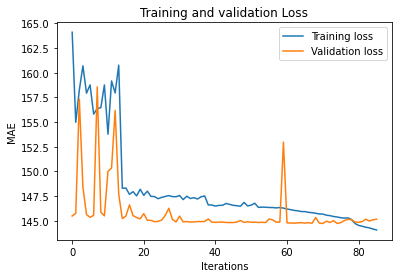

In [18]:
plt.plot(tr_loss, label="Training loss")
plt.plot(test_loss, label="Validation loss")
plt.title("Training and validation Loss")
plt.xlabel("Iterations")
plt.ylabel("MAE")

plt.legend()
plt.show()

##### Saving the model:

In [84]:
torch.save(base_model.state_dict(), "Models/base_model_Bert_12features.pkl")

#### Loading the model:

In [20]:
base_model.load_state_dict(torch.load("Models/base_model_Bert_12features.pkl"))

<All keys matched successfully>

## Testing on data:

In [34]:
input_ids_test = input_ids_test[urls_test]

### Creating data loader

In [21]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

test_dataset = TensorDataset(input_ids_test)

batch_size = 32

# For test data set 
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [22]:
pred = np.array([])

base_model.eval()
with torch.no_grad():
        for i, X in enumerate(test_dataloader):
            X = X[0]
            current_batch_size = X.shape[0]

            preds = base_model(X)
            
            pred = np.append(pred, preds.cpu().numpy())
            #print(y_pred)
            

In [23]:
np.count_nonzero(pred >= 0.01)

210683

In [28]:
print(pred.max())
print(pred.min())
print(pred.mean())
len(pred) == len(eval_data)

2636.301025390625
-86.26107788085938
7.374722741994988


True

In [31]:
y_pred = np.zeros(len(eval_data))
y_pred = pred

In [33]:
with open("Results/base_model_Bert_12features.txt", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "NoRetweets"])
    for index, prediction in enumerate(y_pred):
        writer.writerow([str(eval_data['id'].iloc[index]) , str(prediction if prediction>=1 else 0)])

### Training with fastai

##### Setting up:

In [17]:
## import the tools from fastai:
import fastai
from fastai.basics import *
print(fastai.__version__)


#databunch = DataBunch.create(train_dataset, val_dataset, bs=64, device = torch.device('cuda'))
dls       = DataLoaders(train_dataloader, validation_dataloader)
learn     = Learner(dls, base_model, loss_func = mae, metrics = [mse,mae])



2.1.8


##### Learning

In [18]:
learn.lr_find()
learn.recorder.plot()

AttributeError: 'Learner' object has no attribute 'lr_find'

In [ ]:
learn.fit(n_epoch = 10, lr = 0.001)

In [ ]:
learn.fit(n_epoch = 10, lr = 0.0001)